# This is the Test file for the CNN basic models(blur, night_vis, outline, poster)

Loaded test images: (4, 256, 256, 3)

 Testing style: blur
Loading: /Users/amayakof/Desktop/2025_autumn/deep_learning/SIS/3/project/models/upd/autoencoder_blur_upd.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 927ms/step
Saved results to: /Users/amayakof/Desktop/2025_autumn/deep_learning/SIS/3/project/test/results/adv_mod/blur


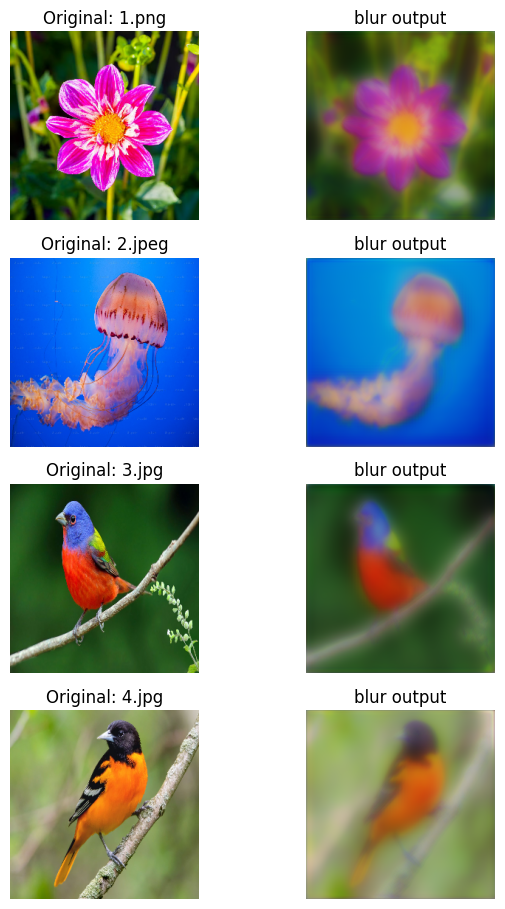


 Testing style: night_vis
MISSING MODEL → /Users/amayakof/Desktop/2025_autumn/deep_learning/SIS/3/project/models/upd/autoencoder_night_vis_upd.keras

 Testing style: poster
MISSING MODEL → /Users/amayakof/Desktop/2025_autumn/deep_learning/SIS/3/project/models/upd/autoencoder_poster_upd.keras

 Testing style: outline
Loading: /Users/amayakof/Desktop/2025_autumn/deep_learning/SIS/3/project/models/upd/autoencoder_outline_upd.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 826ms/step
Saved results to: /Users/amayakof/Desktop/2025_autumn/deep_learning/SIS/3/project/test/results/adv_mod/outline


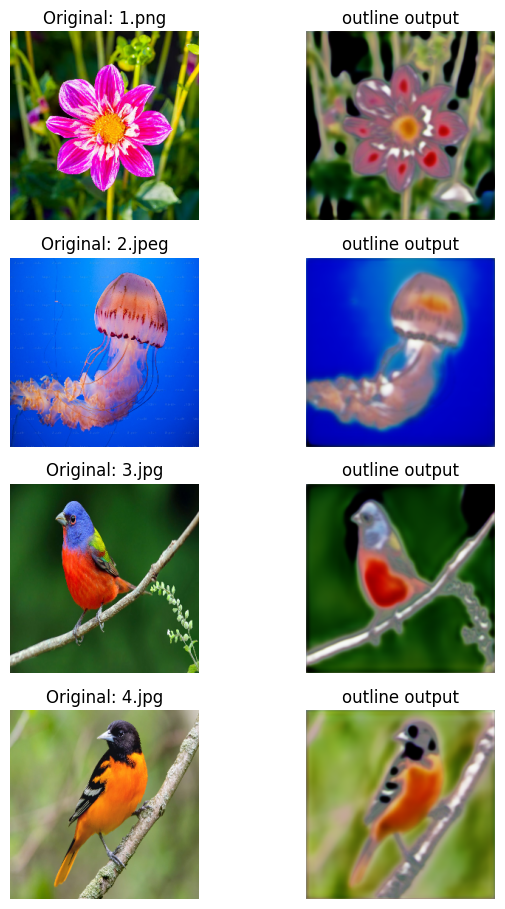

In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
import tensorflow as tf
from tensorflow import keras


# ============================================
# 1. REGISTER CUSTOM LOSS FUNCTIONS FOR LOADING
# ============================================

def mae_basic(y_true, y_pred):
    return tf.reduce_mean(tf.abs(y_true - y_pred))

def nightvis_weighted_mae(y_true, y_pred):
    lum = tf.reduce_mean(y_true, axis=-1, keepdims=True)
    weights = 1 + 4 * lum
    return tf.reduce_mean(weights * tf.abs(y_true - y_pred))


# Keras requires explicit registration when loading
CUSTOM_OBJECTS = {
    "mae_basic": mae_basic,
    "nightvis_weighted_mae": nightvis_weighted_mae,
}


# ============================================
# 2. PATHS
# ============================================

BASE_TEST = "/Users/amayakof/Desktop/2025_autumn/deep_learning/SIS/3/project/test/img"
MODEL_DIR  = "/Users/amayakof/Desktop/2025_autumn/deep_learning/SIS/3/project/models/upd"
RESULT_DIR = "/Users/amayakof/Desktop/2025_autumn/deep_learning/SIS/3/project/test/results/adv_mod"

os.makedirs(RESULT_DIR, exist_ok=True)

IMAGE_SIZE = (256, 256)

STYLES = ["blur", "night_vis", "poster", "outline"]


# ============================================
# 3. LOAD TEST IMAGES
# ============================================

def load_test_images(folder):
    imgs, names = [], []
    for fname in sorted(os.listdir(folder)):
        if not fname.lower().endswith((".png", ".jpg", ".jpeg")):
            continue

        path = os.path.join(folder, fname)
        img = cv2.imread(path)
        if img is None:
            continue

        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, IMAGE_SIZE)
        img = img.astype("float32") / 255.0

        imgs.append(img)
        names.append(fname)

    return np.array(imgs), names


test_imgs, test_names = load_test_images(BASE_TEST)
print("Loaded test images:", test_imgs.shape)


# ============================================
# 4. VISUALIZATION
# ============================================

def show_results_grid(style_name, inputs, outputs, names):
    n = len(inputs)
    plt.figure(figsize=(7, n * 2.3))

    for i in range(n):
        inp = inputs[i]
        out = outputs[i]

        # original
        plt.subplot(n, 2, i*2 + 1)
        plt.imshow(inp)
        plt.title(f"Original: {names[i]}")
        plt.axis("off")

        # stylized
        plt.subplot(n, 2, i*2 + 2)
        plt.imshow(out)
        plt.title(f"{style_name} output")
        plt.axis("off")

    plt.tight_layout()
    plt.show()


# ============================================
# 5. RUN ALL STYLES
# ============================================

for style in STYLES:
    print("\n==============================")
    print(f" Testing style: {style}")
    print("==============================")

    model_path = os.path.join(MODEL_DIR, f"autoencoder_{style}_upd.keras")

    if not os.path.exists(model_path):
        print("MISSING MODEL →", model_path)
        continue

    # SAFE LOADING: supports custom losses
    print("Loading:", model_path)
    model = load_model(model_path, custom_objects=CUSTOM_OBJECTS)

    preds = model.predict(test_imgs)

    # save outputs
    out_dir = os.path.join(RESULT_DIR, style)
    os.makedirs(out_dir, exist_ok=True)

    for arr, fname in zip(preds, test_names):
        out = (arr * 255).astype("uint8")
        out_bgr = cv2.cvtColor(out, cv2.COLOR_RGB2BGR)
        cv2.imwrite(os.path.join(out_dir, fname), out_bgr)

    print("Saved results to:", out_dir)

    # visualization
    show_results_grid(style, test_imgs, preds, test_names)
